# Skull stripping

In [53]:
image_number = 6

In [54]:
import cv2
import numpy as np

def load_image(image_path):
    """ Load an image from a specified path. """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image could not be read. Check the path.")
    return image

def create_skull_mask(image):
    """ Create a mask to remove skull by setting skull pixels to 0 and all other to 1. """
    # Assuming skull pixels are exactly 255
    skull_mask = np.where(image == 255, 0, 1).astype('uint8')
    return skull_mask

def apply_mask(image, mask):
    """ Apply the created mask to the original image to isolate brain and vessels. """
    brain_and_vessels = cv2.multiply(image, mask)
    return brain_and_vessels

def save_image(image, output_path):
    """ Save the processed image to a specified path. """
    cv2.imwrite(output_path, image)

def display_image(image, window_name='Image'):
    """ Display an image until a key is pressed. """
    cv2.imshow(window_name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main():
    image_path = f"/Users/selimgul/Desktop/photos/{image_number}_resized.png"
    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_brain_vessels.png'
    
    # Load the original grayscale image
    image = load_image(image_path)
    
    # Create a mask to remove the skull
    skull_mask = create_skull_mask(image)
    
    # Apply the mask to the original image to remove the skull
    brain_and_vessels = apply_mask(image, skull_mask)
    
    # Save the resultant image
    save_image(brain_and_vessels, output_path)
    
    # Display the resultant image
    display_image(brain_and_vessels, 'Brain and Vessels')

if __name__ == "__main__":
    main()


# Preprocessing

In [55]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image could not be read. Check the path.")
        exit()

    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(blurred_image)

    return enhanced_image

def apply_thresholds(enhanced_image):
    # Set threshold values
    vessel_hu_min = 75  # Lower bound for blood vessels
    vessel_hu_max = 200  # Upper bound avoiding bones

    # Apply thresholds
    _, lower_thresh_image = cv2.threshold(enhanced_image, vessel_hu_min, 255, cv2.THRESH_BINARY)
    _, upper_thresh_image = cv2.threshold(enhanced_image, vessel_hu_max, 255, cv2.THRESH_BINARY_INV)
    
    # Combine the thresholds to isolate the vessels
    vessel_image = cv2.bitwise_and(lower_thresh_image, upper_thresh_image)
    return vessel_image

def apply_adaptive_thresholds(enhanced_image):
    # Apply adaptive threshold
    adaptive_thresh = cv2.adaptiveThreshold(
        enhanced_image,  # Source image
        255,  # Maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Adaptive method - using Gaussian (weighted sum of neighbourhood values)
        cv2.THRESH_BINARY_INV,  # Thresholding type
        11,  # Block size - size of a pixel neighborhood used to calculate a threshold value
        2   # Constant subtracted from the mean or weighted mean
    )
    return adaptive_thresh


def display_images(images):
    # Display each image in the dictionary
    for title, img in images.items():
        cv2.imshow(title, img)
        print(f"{title} - Min HU: {np.min(img)}, Max HU: {np.max(img)}, Mean HU: {np.mean(img)}, Std HU: {np.std(img)}")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main():
    image_path = f'/Users/selimgul/Desktop/photos/{image_number}_brain_vessels.png'
    enhanced_image = load_and_preprocess_image(image_path)
    vessel_image = apply_adaptive_thresholds(enhanced_image)

    #save vessel image
    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_vessels.png'
    cv2.imwrite(output_path, vessel_image)

    images = {
        "Enhanced Image": enhanced_image,
        "Vessel Image": vessel_image,
    }
    
    display_images(images)

if __name__ == "__main__":
    main()


Enhanced Image - Min HU: 2, Max HU: 247, Mean HU: 42.14890670776367, Std HU: 54.71201907190469
Vessel Image - Min HU: 0, Max HU: 255, Mean HU: 63.678016662597656, Std HU: 110.3766480868138


In [21]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Error: Image could not be read. Check the path.")
    
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Histogram Equalization
    equalized_image = cv2.equalizeHist(blurred_image)

    return equalized_image

def apply_thresholds(image):
    # Set threshold values
    vessel_hu_min = 75  # Lower bound for blood vessels
    vessel_hu_max = 200  # Upper bound avoiding bones

    # Apply thresholds
    _, lower_thresh_image = cv2.threshold(image, vessel_hu_min, 255, cv2.THRESH_BINARY)
    _, upper_thresh_image = cv2.threshold(image, vessel_hu_max, 255, cv2.THRESH_BINARY_INV)

    # Combine the thresholds to isolate the vessels
    vessel_image = cv2.bitwise_and(lower_thresh_image, upper_thresh_image)
    return vessel_image

def clean_and_label_vessels(vessel_image):
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned_vessel_image = cv2.morphologyEx(vessel_image, cv2.MORPH_OPEN, kernel)
    cleaned_vessel_image = cv2.morphologyEx(cleaned_vessel_image, cv2.MORPH_CLOSE, kernel)
    return cleaned_vessel_image

def connected_components_analysis(image):
    # Perform connected components analysis
    num_labels, labels_im = cv2.connectedComponents(image)
    min_size = 50
    filtered_labels_im = np.zeros_like(labels_im, dtype=np.uint8)
    for i in range(1, num_labels):
        if np.sum(labels_im == i) > min_size:
            filtered_labels_im[labels_im == i] = 255
    return filtered_labels_im

def edge_detection(image):
    # Apply edge detection using Canny
    edges = cv2.Canny(image, 100, 200)
    return edges

def display_images(images):
    # Display each image in the dictionary
    for title, img in images.items():
        cv2.imshow(title, img)
        print(f"{title} - Min HU: {np.min(img)}, Max HU: {np.max(img)}, Mean HU: {np.mean(img)}, Std HU: {np.std(img)}")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main(image_number):
    image_path = f'/Users/selimgul/Desktop/photos/{image_number}_brain_vessels.png'
    enhanced_image = load_and_preprocess_image(image_path)
    vessel_image = apply_thresholds(enhanced_image)
    cleaned_vessel_image = clean_and_label_vessels(vessel_image)

    # Apply connected components analysis to extract vessels
    filtered_labels_im = connected_components_analysis(cleaned_vessel_image)

    # Apply edge detection to extract vessel boundaries
    edges = edge_detection(filtered_labels_im)

    #save the vessel image
    cv2.imwrite(f'/Users/selimgul/Desktop/photos/{image_number}_vessel_image.png', cleaned_vessel_image)

    images = {
        "Enhanced Image": enhanced_image,
        "Vessel Image": vessel_image,
        "Processed Vessel Image": cleaned_vessel_image,
        "Filtered Vessel Image": filtered_labels_im,
        "Vessel Edges": edges
    }
    
    display_images(images)

if __name__ == "__main__":
    main(image_number)


Enhanced Image - Min HU: 0, Max HU: 255, Mean HU: 68.69857747020377, Std HU: 84.24398649042426
Vessel Image - Min HU: 0, Max HU: 255, Mean HU: 66.04705882352941, Std HU: 111.71296263532378
Processed Vessel Image - Min HU: 0, Max HU: 255, Mean HU: 63.207843137254905, Std HU: 110.10344484136803
Filtered Vessel Image - Min HU: 0, Max HU: 255, Mean HU: 62.09803921568628, Std HU: 109.44785756499344
Vessel Edges - Min HU: 0, Max HU: 255, Mean HU: 6.858823529411764, Std HU: 41.25477596342498


# ROI Selection

In [30]:
import cv2
import numpy as np

# Function to handle mouse events
def click_and_crop(event, x, y, flags, param):
    # Reference to the global variables
    global roi, cropping, image

    # Start the cropping with a mouse click
    if event == cv2.EVENT_LBUTTONDOWN:
        roi = [(x, y)]
        cropping = True

    # Finish the cropping with mouse release, draw rectangle, and show coordinates
    elif event == cv2.EVENT_LBUTTONUP:
        roi.append((x, y))
        cropping = False
        cv2.rectangle(image, roi[0], (x, y), (0, 255, 0), 2)
        cv2.imshow("image", image)
        print("ROI Selected - Coordinates: ({}, {}) to ({}, {})".format(roi[0][0], roi[0][1], abs(roi[0][0] - x), abs(roi[0][1] - y)))
        cv2.waitKey(500)  # Display for 500 ms then close automatically
        cv2.destroyWindow("image")

def main():
    global image
    image_path = f"/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png"  # Change to your image path
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    cv2.namedWindow("image")
    cv2.setMouseCallback("image", click_and_crop)

    # Display the image and wait until user finishes selecting the ROI
    cv2.imshow("image", image)
    cv2.waitKey(0)
    
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()


ROI Selected - Coordinates: (99, 79) to (69, 69)


In [56]:
import cv2
import numpy as np

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image could not be read. Check the path.")
    return image

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

def threshold_image(image, low_thresh, high_thresh):
    _, low = cv2.threshold(image, low_thresh, 255, cv2.THRESH_BINARY)
    _, high = cv2.threshold(image, high_thresh, 255, cv2.THRESH_BINARY_INV)
    return cv2.bitwise_and(low, high)

def clean_image(image, kernel_size=(1, 1), operation_iter=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=operation_iter)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=operation_iter)
    return closing

def remove_small_objects(image, min_size):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    output = np.zeros_like(labels, dtype=np.uint8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255
    return output

def main():
    image_path = f'/Users/selimgul/Desktop/photos/{image_number}_brain_vessels.png'
    image = load_image(image_path)

    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    enhanced_image = apply_clahe(blurred_image)

    vessel_image = threshold_image(enhanced_image, 110, 200)
    cleaned_vessel_image = clean_image(vessel_image, kernel_size=(3, 3), operation_iter=2)
    final_vessel_image = remove_small_objects(cleaned_vessel_image, min_size=50)

    #Save enhanced and vessel image
    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png'
    cv2.imwrite(output_path, enhanced_image)

    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_vessel_image.png'
    cv2.imwrite(output_path, vessel_image)

    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_cleaned_vessel_image.png'
    cv2.imwrite(output_path, cleaned_vessel_image)

    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_final_vessel_image.png'
    cv2.imwrite(output_path, final_vessel_image)

    cv2.imshow('Original Image', image)
    cv2.imshow('CLAHE Enhanced Image', enhanced_image)
    cv2.imshow('Vessel Image', vessel_image)
    cv2.imshow('Cleaned Vessel Image', cleaned_vessel_image)
    cv2.imshow('Final Vessel Image', final_vessel_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [8]:
import cv2
import numpy as np

def analyze_vessel_intensity(enhanced_image, vessel_mask, roi_coords):
    x, y, w, h = roi_coords
    vessel_roi = vessel_mask[y:y+h, x:x+w]
    enhanced_roi = enhanced_image[y:y+h, x:x+w]

    # Apply the vessel mask to the enhanced ROI to focus on vessel intensities
    vessel_intensity = cv2.bitwise_and(enhanced_roi, enhanced_roi, mask=vessel_roi)

    # Calculate the gradient magnitude
    grad_x = cv2.Sobel(vessel_intensity, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(vessel_intensity, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(grad_x, grad_y)

    # Threshold the gradient to identify significant changes
    _, significant_changes = cv2.threshold(grad_mag, 50, 255, cv2.THRESH_BINARY)

    # Overlay the significant changes on the original enhanced image
    overlay = enhanced_image.copy()
    overlay[y:y+h, x:x+w][significant_changes > 0] = 255  # Highlight changes

    # Calculate statistics
    stats = {
        'mean': np.mean(grad_mag[significant_changes > 0]),
        'std_dev': np.std(grad_mag[significant_changes > 0]),
        'change_area': np.count_nonzero(significant_changes > 0)
    }

    return overlay, stats

# Load images
enhanced_image = cv2.imread(f'/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png', cv2.IMREAD_GRAYSCALE)
vessel_mask = cv2.imread(f'/Users/selimgul/Desktop/photos/{image_number}_vessel_image.png', cv2.IMREAD_GRAYSCALE)

# Define ROI coordinates (x, y, width, height)
roi_coords = 157, 202, 155, 207  # Example values

# Perform analysis
overlay_image, stats = analyze_vessel_intensity(enhanced_image, vessel_mask, roi_coords)

# Display significant changes overlaid on the original image
cv2.imshow('Overlay of Significant Changes on Enhanced Image', overlay_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print statistical analysis
print("Statistics within ROI:")
print("Mean Gradient Magnitude:", stats['mean'])
print("Standard Deviation of Gradient Magnitude:", stats['std_dev'])
print("Area of Significant Changes (in pixels):", stats['change_area'])


Statistics within ROI:
Mean Gradient Magnitude: 368.9435027817831
Standard Deviation of Gradient Magnitude: 203.23661943980352
Area of Significant Changes (in pixels): 8649


In [9]:
import cv2
import numpy as np

def main():
    image_number = 3  # example number
    image_path = f'/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png'
    vessel_mask_path = f'/Users/selimgul/Desktop/photos/{image_number}_vessel_image.png'
    
    enhanced_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    vessel_mask = cv2.imread(vessel_mask_path, cv2.IMREAD_GRAYSCALE)

    if enhanced_image is None or vessel_mask is None:
        print("Error loading images")
        return

    # Ensure the vessel mask is binary for proper visualization
    _, vessel_mask = cv2.threshold(vessel_mask, 150, 255, cv2.THRESH_BINARY)

    # Create a color version of the enhanced image to overlay the vessels in color
    color_enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)

    # Overlay vessel mask in red on the enhanced image
    color_enhanced_image[vessel_mask == 255] = [0, 0, 255]  # BGR format for red

    # Display the overlay image
    cv2.imshow('Overlay of Vessels on Enhanced Image', color_enhanced_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


# See the greyscale values 

192
64
84
76
131
84
77
75
77
90
79
88
79
63
73
74
74
75
75
55
112
80
84
89
81


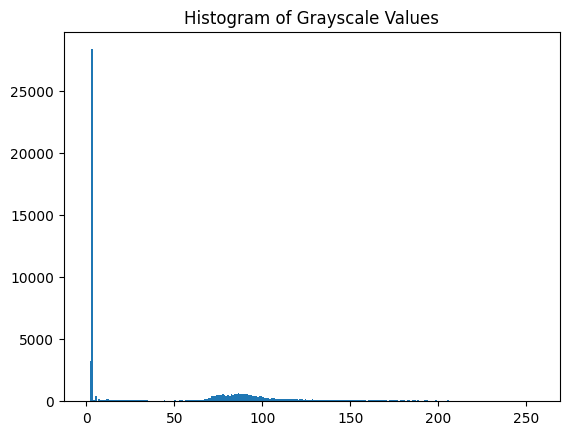

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = f"/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image and use OpenCV's built-in functionality to click and see pixel values
cv2.imshow('Click on the skull to see pixel values', image)
cv2.setMouseCallback('Click on the skull to see pixel values', lambda event, x, y, flags, param: print(image[y, x]) if event == cv2.EVENT_LBUTTONDOWN else None)
cv2.waitKey(0)

# Alternatively, generate a histogram of the grayscale values
plt.hist(image.ravel(), 256, [0, 256])
plt.title('Histogram of Grayscale Values')
plt.show()

# Analyze the histogram to estimate where the skull might be
# Typically, you will see a peak at the higher end of the grayscale values
# Adjust the range below according to your observations
possible_skull_intensity_range = (180, 255)  # This is an example range, adjust it according to your histogram

# Apply threshold to visualize the estimated skull area
_, skull_mask = cv2.threshold(image, possible_skull_intensity_range[0], possible_skull_intensity_range[1], cv2.THRESH_BINARY)
cv2.imshow('Estimated Skull Area', skull_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


# ChatGPT Connection

In [47]:
from openai import OpenAI

API_KEY = ""
image_url = "https://ibb.co/MRTFKw4"

question = input("Ask a question about the image")

client = OpenAI(
    api_key=API_KEY,
)

stream = client.chat.completions.create(
    messages=[{"role": "user", "content": f"The following is a CT scan image of a brain: {image_url}\n\n Answer the question about this image:{question}",}],
    stream=True,
    model="gpt-4-turbo",
)


for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")



Since I can't view images or specific URLs including "https://ibb.co/MRTFKw4", I will base my response on a typical scenario of what you described—a CT scan of a brain with an area marked in red to indicate an occlusion.

1. **Understanding the Image**: The CT scan you're referring to shows an image of a brain, and typically such scans are used medically to view the internal structures of the skull. This can help identify issues like bleeding, tumors, or blockages.

2. **Identifying the Occlusion**: In medical terms, an "occlusion" usually refers to the blockage of a blood vessel. When a tool that you developed marks an area in red, it highlights the area on the CT scan where an occlusion is detected. The primary reason to mark such an area is to isolate and identify the specific location and extent of the blockage.

3. **Implications of the Output**:
   - **Medical Diagnosis**: The red mark helps medical professionals quickly and clearly identify where the blockage is, which is crucia

# Resize image to 255x255

In [18]:
import cv2

def resize_image(image_path, output_size=(255, 255)):
    # Load the image from the specified path
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("The image file was not found.")

    # Resize the image to the output_size
    resized_image = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)

    return resized_image

image_path = f'/Users/selimgul/Desktop/photos/{image_number}.png'  # Replace this with your image's path
resized_image = resize_image(image_path)

# If you want to display the resized image
cv2.imshow("Resized Image", resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# If you want to save the resized image
output_image_path = f'/Users/selimgul/Desktop/photos/{image_number}_resized.png'  # Replace with your desired output path
cv2.imwrite(output_image_path, resized_image)


True

# Significance around vessels

In [48]:
import cv2
import numpy as np

def detect_edges(image):
    """Detect edges using the Sobel operator."""
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    _, edge_mask = cv2.threshold(grad_mag, 50, 255, cv2.THRESH_BINARY)
    return edge_mask.astype(np.uint8)  # Ensure mask is binary type uint8

def dilate_edges(edge_mask, kernel_size=(5,5)):
    """Dilate edges to include adjacent tissue areas in the analysis."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    dilated_edges = cv2.dilate(edge_mask, kernel, iterations=1)
    return dilated_edges

def compare_intensities(image, dilated_edges, original_edges):
    """Calculate mean intensity inside and just outside the vessel edges."""
    # Ensure masks are binary and type uint8
    outside_mask = cv2.subtract(dilated_edges, original_edges).astype(np.uint8)
    
    inside_intensity = cv2.mean(image, mask=original_edges)[0]
    outside_intensity = cv2.mean(image, mask=outside_mask)[0]
    
    intensity_difference = abs(inside_intensity - outside_intensity)
    
    return inside_intensity, outside_intensity, intensity_difference

# Load the image
enhanced_image = cv2.imread('/Users/selimgul/Desktop/photos/12_enhanced_image.png', cv2.IMREAD_GRAYSCALE)
x, y, width, height = 99, 79, 69, 69


# Validate ROI dimensions
if y + height > enhanced_image.shape[0] or x + width > enhanced_image.shape[1]:
    raise ValueError("ROI dimensions exceed the image dimensions.")

# Extract the ROI from the image
enhanced_roi = enhanced_image[y:y+height, x:x+width]

# Edge detection and dilation
edge_mask = detect_edges(enhanced_roi)
dilated_edges = dilate_edges(edge_mask)

# Intensity comparison
inside_int, outside_int, diff = compare_intensities(enhanced_roi, dilated_edges, edge_mask)
print("Mean intensity inside edges:", inside_int)
print("Mean intensity outside edges:", outside_int)
print("Intensity difference:", diff)

# Threshold to detect significant changes
significant_change_threshold = 27
if diff > significant_change_threshold:
    print("Significant occlusion detected")
else:
    print("No significant occlusion detected")

significant_mask = np.zeros_like(enhanced_image, dtype=np.uint8)
significant_mask[y:y+height, x:x+width] = dilated_edges

color_enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
color_enhanced_image[significant_mask == 255] = [0, 0, 255]  # Highlight changes in red


# Display images
cv2.imshow('Enhanced Image', enhanced_image)
cv2.imshow('Enhanced ROI', enhanced_roi)
cv2.imshow('Edge Mask', edge_mask)
cv2.imshow('Dilated Edges', dilated_edges)
cv2.imshow('Significant Changes Overlay on Enhanced Image', color_enhanced_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


Mean intensity inside edges: 108.60121765601217
Mean intensity outside edges: 84.75454545454545
Intensity difference: 23.846672201466717
No significant occlusion detected


In [15]:
def dilate_edges(edge_mask, kernel_size=(5,5)):
    """Dilate edges to include adjacent tissue areas in the analysis."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    dilated_edges = cv2.dilate(edge_mask, kernel, iterations=1)
    return dilated_edges


In [16]:
def calculate_significant_differences(image, dilated_edges, original_edges, threshold):
    """Calculate absolute intensity difference for each pixel and create a visualization mask."""
    # Calculate the absolute intensity difference for each pixel
    intensity_difference = cv2.absdiff(cv2.blur(image, (3, 3)), cv2.blur(image, (5, 5)))
    
    # Create a mask based on the threshold
    _, significant_mask = cv2.threshold(intensity_difference, threshold, 255, cv2.THRESH_BINARY)
    
    # Apply the dilated edges mask to focus only on regions around the edges
    significant_mask = cv2.bitwise_and(significant_mask, significant_mask, mask=dilated_edges - original_edges)
    
    return significant_mask

def clean_and_label_vessels(vessel_image):
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned_vessel_image = cv2.morphologyEx(vessel_image, cv2.MORPH_OPEN, kernel)
    cleaned_vessel_image = cv2.morphologyEx(cleaned_vessel_image, cv2.MORPH_CLOSE, kernel)
    return cleaned_vessel_image

def display_images(images):
    # Display each image in the dictionary
    for title, img in images.items():
        cv2.imshow(title, img)
        print(f"{title} - Min HU: {np.min(img)}, Max HU: {np.max(img)}, Mean HU: {np.mean(img)}, Std HU: {np.std(img)}")
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [42]:
import cv2
import numpy as np
from scipy.stats import f_oneway

def calculate_differences(image, rois):
    differences = []
    for (x, y, w, h) in rois:
        roi = image[y:y+h, x:x+w]
        local_mean = cv2.blur(roi, (5,5))  # Example local mean computation
        diff = np.abs(roi - local_mean)
        differences.append(diff.flatten())
    return differences

def perform_statistical_test(differences):
    f_val, p_val = f_oneway(*differences)
    return f_val, p_val

def detect_edges(image):
    """Detect edges using the Sobel operator within the ROI."""
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    _, edge_mask = cv2.threshold(grad_mag, 50, 255, cv2.THRESH_BINARY)
    return edge_mask.astype(np.uint8)

def dilate_edges(edge_mask, kernel_size=(3,3)):
    """Dilate edges to include just outside the vessel edges within the ROI."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    dilated_edges = cv2.dilate(edge_mask, kernel, iterations=1)
    return dilated_edges

def calculate_significant_differences(image, dilated_edges, original_edges, threshold):
    """Calculate significant differences at the pixel level and create a mask within the ROI."""
    # Create masks for inside and just outside the vessel edges
    inside_mask = original_edges.astype(np.uint8)
    outside_mask = cv2.subtract(dilated_edges, original_edges).astype(np.uint8)
    
    # Calculate pixel-wise intensity differences where the masks are applied
    intensity_difference = cv2.absdiff(cv2.bitwise_and(image, image, mask=inside_mask),
                                       cv2.bitwise_and(image, image, mask=outside_mask))
    
    # Apply a threshold to find significant differences
    _, significant_mask = cv2.threshold(intensity_difference, threshold, 255, cv2.THRESH_BINARY)
    return significant_mask

# Load the image
enhanced_image = cv2.imread(f'/Users/selimgul/Desktop/photos/{image_number}_enhanced_image.png', cv2.IMREAD_GRAYSCALE)
if enhanced_image is None:
    raise FileNotFoundError("Image could not be read. Check the path.")

x, y, width, height = 90, 90, 39, 53  # Define the coordinates of your ROI
enhanced_roi = enhanced_image[y:y+height, x:x+width]  # Extract the ROI

#ROIs should be adjusted according to the image
rois = [(10, 10, 50, 50), (70, 70, 50, 50), (130, 130, 50, 50)]
differences = calculate_differences(image, rois)
f_val, p_val = perform_statistical_test(differences)

print("ANOVA F-value:", f_val)
print("ANOVA P-value:", p_val)

if p_val < 0.05: 
    print("Significant differences found between ROIs")
    # Edge detection and dilation within the ROI
    edge_mask = detect_edges(enhanced_roi)
    dilated_edges = dilate_edges(edge_mask)

    # Find significant differences within the ROI
    significant_change_threshold = 180  # Define your specific intensity difference threshold
    significant_mask = calculate_significant_differences(enhanced_roi, dilated_edges, edge_mask, significant_change_threshold)

    # Create a full-size mask to overlay on the original enhanced image
    full_size_mask = np.zeros_like(enhanced_image, dtype=np.uint8)
    full_size_mask[y:y+height, x:x+width] = significant_mask  # Place the ROI mask back into the full image context

    # Overlay significant changes on the original image
    color_enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    color_enhanced_image[full_size_mask == 255] = [0, 0, 255]  # Highlight significant changes in red

    #output color enhanced image
    output_path = f'/Users/selimgul/Desktop/photos/{image_number}_color_enhanced_image.png'
    cv2.imwrite(output_path, color_enhanced_image)

    # Display images
    cv2.imshow('Original Image', enhanced_image)
    cv2.imshow('Significant Changes Overlay', color_enhanced_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No significant differences found between ROIs")